# **The Black-Scholes Model Option Pricing Model and Option Greeks**

### **Import Base Packages**

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

from scipy.stats import norm

---

---

## **Generate Parameters**

### **Stock Prices**

In [7]:
# Generate Option Price using yfinance
import yfinance as yf

In [8]:
# Generate historical Adj Close stock data for Microsoft across all time periods
stock_prices = yf.download('MSFT', period = 'max', rounding = True)['Adj Close']
stock_prices

[*********************100%***********************]  1 of 1 completed


Date
1986-03-13      0.06
1986-03-14      0.06
1986-03-17      0.06
1986-03-18      0.06
1986-03-19      0.06
               ...  
2023-08-28    323.70
2023-08-29    328.41
2023-08-30    328.79
2023-08-31    327.76
2023-09-01    328.66
Name: Adj Close, Length: 9445, dtype: float64

<Axes: xlabel='Date', ylabel='Adj Close'>

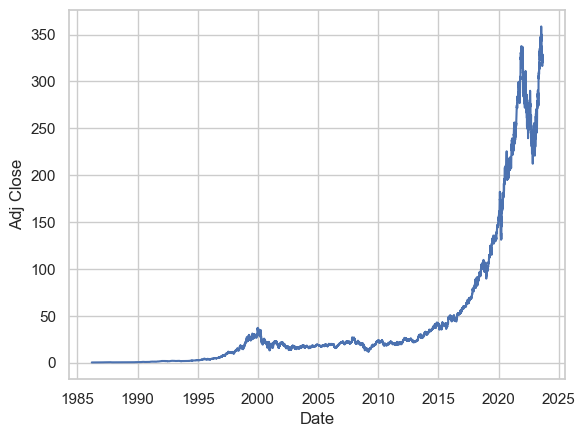

In [9]:
# Visualize Historical Prices
sns.set(style = 'whitegrid')
sns.lineplot(data = stock_prices)

In [10]:
# Check for Missing Values
stock_prices.isna().sum()

0

- No missing values are present in the data, allowing for direct utilization. However, if any gaps exist, an imputation approach would need to be implemented.

In [11]:
# Get Current Stock Price
S = stock_prices.tail(1).values[0]
S

328.66

---

### **Historical Volatility**

To calculate historical volatility, the initial step involves calculating the logarithmic returns of the stock.

In [12]:
# Log Returns
log_returns = np.log(stock_prices / stock_prices.shift(1)).dropna()
log_returns

Date
1986-03-14    0.000000
1986-03-17    0.000000
1986-03-18    0.000000
1986-03-19    0.000000
1986-03-20    0.000000
                ...   
2023-08-28    0.002227
2023-08-29    0.014446
2023-08-30    0.001156
2023-08-31   -0.003138
2023-09-01    0.002742
Name: Adj Close, Length: 9444, dtype: float64

<Axes: xlabel='Date', ylabel='Adj Close'>

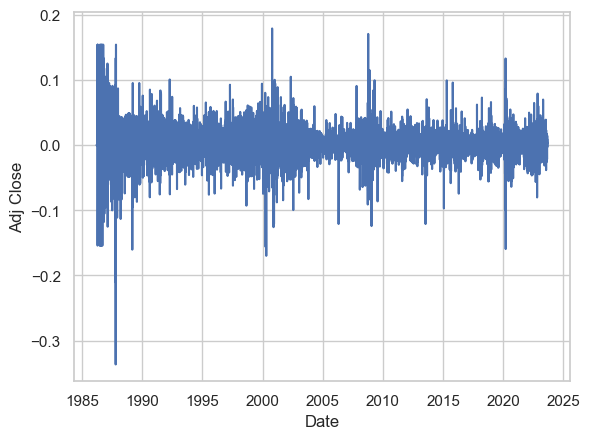

In [13]:
# Visualize the log returns
sns.lineplot(data = log_returns)

<Axes: xlabel='Adj Close', ylabel='Count'>

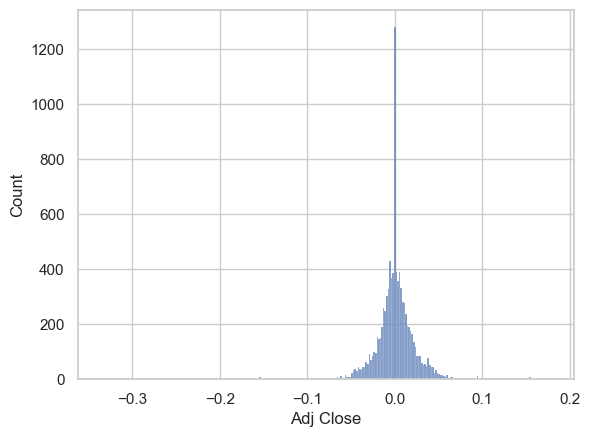

In [14]:
# Log returns histogram
sns.histplot(data = log_returns)

- The stock's rate of returns follows a pattern resembling a Normal Distribution with minor fluctuations.

In [15]:
# Daily Standard Deviation of Returns
daily_std = log_returns.std()
daily_std

0.023114393420189283

- Keep in mind that the provided data is in a daily format. It's essential to convert the volatility into an annualized measure.

In [16]:
# Annualized Standard Deviation of Returns
# 252 Trading days
annualized_std = daily_std * np.sqrt(252)
annualized_std

0.3669296201755713

---

### **Risk-free Rate**

- Risk free rate is generated from 13 Week Treasury Bill

In [17]:
# The latest risk free rate of 13 Week Treasury Bill
r = yf.download('^IRX')['Adj Close'].tail(1)*0.01
r = r.values[0]
r

[*********************100%***********************]  1 of 1 completed


0.0526800012588501

In [18]:
# r = yf.download('^IRX')['Adj Close']
# r

---

### **Time to Maturity**

A breakdown of the different option expiration cycles:

1. Weekly Options: Weekly options have relatively short expiration periods, typically expiring on Fridays of each week. They offer more frequent opportunities for trading and can be useful for short-term trading strategies. Weekly options are introduced on a variety of underlying assets and are popular among active traders.

2. Monthly Options: Monthly options have longer expiration periods and typically expire on the third Friday of each month. These are often referred to as "standard" or "regular" options. They are widely traded and available for a wide range of underlying assets, including stocks, indices, and exchange-traded funds (ETFs).

3. Quarterly Options: Some options are structured with quarterly expiration dates, typically expiring on the last trading day of March, June, September, and December. These options are also known as "serial" options and are used less frequently than weekly and monthly options.

4. LEAPS (Long-Term Equity Anticipation Securities): LEAPS are long-term options with expiration dates that can extend up to several years into the future. They are often used for longer-term investment strategies or hedging purposes.

Options Expiration Calender: https://www.marketwatch.com/tools/options-expiration-calendar

- This project deals with options that expire on a monthly basis.

In [19]:
# Monthly Expirations: Every third Friday of the month


def get_third_fridays(year = datetime.today().year, month = datetime.today().month, num_dates = 1):
    third_fridays = []

    for _ in range(num_dates):
        dt = datetime(year, month, 1)  # Start from the first day of the month
        while dt.weekday() != 4:       # Find the first Friday
            dt = dt + timedelta(days=1)
        
        # Move to the third Friday
        dt = dt + timedelta(weeks=2)
        
        # Append third Friday's date to the list
        
        third_fridays.append(dt)
        
        # Proceed to the next month
        month = month + 1
        if month > 12:
            year = year + 1
            month = 1
    
    return third_fridays

third_fridays = get_third_fridays(num_dates=5)
third_fridays

[datetime.datetime(2023, 9, 15, 0, 0),
 datetime.datetime(2023, 10, 20, 0, 0),
 datetime.datetime(2023, 11, 17, 0, 0),
 datetime.datetime(2023, 12, 15, 0, 0),
 datetime.datetime(2024, 1, 19, 0, 0)]

In [20]:
# Maturity Date
third_fridays[1]

datetime.datetime(2023, 10, 20, 0, 0)

In [21]:
# Days to maturity
t = third_fridays[1] - datetime.today()
t = t.days
t

45

- There are "t" days left until maturity. Subsequently, the maturity period must be converted either to an annual or trading days format.

---

---

## **Parameters**

In [22]:
# Current Stock Price
S

328.66

In [23]:
# Strike Price
K = S.round(0) + 5
K

334.0

- Assume the Strike Price at $5 higher than the current stock price.

In [24]:
# Time To Maturity (Days)
t

45

As said before, the maturity period must be converted either to an annual or trading days format. In this case, it is converted to trading days format.

In [25]:
# Time in years
T = t / 252
T

0.17857142857142858

In [26]:
# Annualized Volatility
sigma = annualized_std
sigma

0.3669296201755713

In [27]:
# Risk-free Rate
# r

---

---

## **Black-Scholes Option Pricing Formula**

In [28]:
from scipy.stats import norm

def bs(S, K, t, r, sigma, option_type = 'c'):
    '''
    Calculate Option Price and Greeks with Black-Scholes Formula
    S = Stock Price
    K = Strike Price
    t = Time to Maturity (days)
    r = Risk-free rate
    sigma = Annualized Volatility (Standard Deviation of Returns)
    option_type = Type of Option: 'c' for call, 'p' for put
    '''

    T = t / 252   # Daily to Yearly Time to Maturity

    d1 = (np.log(S / K) + (r + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    try:
        if option_type == 'c':
            norm_d1 = norm.cdf(d1)
            norm_d2 = norm.cdf(d2)
            option_price = S * norm_d1 - K * np.exp(-r * T) * norm_d2
        elif option_type == 'p':
            norm_minus_d1 = norm.cdf(-d1)
            norm_minus_d2 = norm.cdf(-d2)
            option_price = K * np.exp(-r * T) * norm_minus_d2 - S * norm_minus_d1
        else:
            raise ValueError("Invalid option type. Use 'c' for call and 'p' for put.")
        
    # Option Greeks
    
        delta = norm_d1 if option_type == 'c' else norm_minus_d1 - 1
        theta = ((-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm_d2)) / 252 if option_type == 'c' else \
                ((-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * norm_minus_d2)) / 252
        gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
        vega  = S * np.sqrt(T) * norm.pdf(d1) * sigma
        rho   = K * T * np.exp(-r * T) * norm_d2 if option_type == 'c' else \
                -K * T * np.exp(-r * T) * norm_minus_d2
            
    except:
        print('Invalid Input, Check the Parameters')
        return None

    return option_price.round(4), delta.round(4), theta.round(4), gamma.round(4), vega.round(4), rho.round(4)


- Option Price and Option Greeks for European Call Option:

In [29]:
# Call Option
c_price, c_delta, c_theta, c_gamma, c_vega, c_rho = bs(S, K, t, r, sigma, option_type = 'c')
print(f'Option Price: {c_price}')
print(f'Delta: {c_delta}')
print(f'Theta: {c_theta}')
print(f'Gamma: {c_gamma}')
print(f'Vega: {c_vega}')
print(f'Rho: {c_rho}')

Option Price: 19.2911
Delta: 0.5137
Theta: -0.257
Gamma: 0.0078
Vega: 20.3185
Rho: 26.7016


- Option Price and Option Greeks for European Put Option:

In [30]:
# Put Option
p_price, p_delta, p_theta, p_gamma, p_vega, p_rho = bs(S, K, t, r, sigma, option_type = 'p')
print(f'Option Price: {p_price}')
print(f'Delta: {p_delta}')
print(f'Theta: {p_theta}')
print(f'Gamma: {p_gamma}')
print(f'Vega: {p_vega}')
print(f'Rho: {p_rho}')

Option Price: 21.5038
Delta: -0.5137
Theta: -0.1879
Gamma: 0.0078
Vega: 20.3185
Rho: -32.3828


- Until this point, the Black-Scholes Option Pricing Model has been applied using real-world data. It would be advantageous to visualize relevant graphs, such as profit/loss graphs, variations of Greeks, and even 3D representations of option Greeks, to enhance understanding.

---

---

## **The Option DataFrame**

### **Call Option P/L**

- Generate a profit/loss profile based on the corresponding stock prices.

In [31]:
call_graph = pd.DataFrame({'stock_price': np.arange(S-70,S+70,0.01)})

call_graph['pnl_long'] = np.maximum(0, call_graph.stock_price - K) - c_price
call_graph['pnl_short'] = -call_graph['pnl_long']

call_graph.head()

,stock_price,pnl_long,pnl_short
0,258.66,-19.2911,19.2911
1,258.67,-19.2911,19.2911
2,258.68,-19.2911,19.2911
3,258.69,-19.2911,19.2911
4,258.70,-19.2911,19.2911


### **Call Option Price and Greeks**

- Generate a option price and greeks based on the corresponding stock prices.

In [32]:
list_column = ['option_price', 'delta', 'theta', 'gamma', 'vega', 'rho']
for index, value in enumerate(list_column):
    call_graph[f'call_{value}'] = bs(S = call_graph.stock_price, K = K, t = t, r = r, sigma = sigma, option_type = 'c')[index]

call_graph.head()

,stock_price,pnl_long,pnl_short,call_option_price,call_delta,call_theta,call_gamma,call_vega,call_rho
0,258.66,-19.2911,19.2911,1.0822,0.0655,-0.0601,0.0032,5.1138,2.8307
1,258.67,-19.2911,19.2911,1.0829,0.0655,-0.0602,0.0032,5.1159,2.8322
2,258.68,-19.2911,19.2911,1.0835,0.0655,-0.0602,0.0032,5.1180,2.8337
3,258.69,-19.2911,19.2911,1.0842,0.0656,-0.0602,0.0032,5.1202,2.8351
4,258.70,-19.2911,19.2911,1.0849,0.0656,-0.0602,0.0032,5.1223,2.8366


---

### **Put Option P/L**

- Generate a profit/loss profile based on the corresponding stock prices.

In [33]:
put_graph = pd.DataFrame({'stock_price': call_graph.stock_price})

put_graph['pnl_long'] = np.maximum(0, K - put_graph.stock_price) - p_price
put_graph['pnl_short'] = -put_graph['pnl_long']

put_graph.head()

,stock_price,pnl_long,pnl_short
0,258.66,53.8362,-53.8362
1,258.67,53.8262,-53.8262
2,258.68,53.8162,-53.8162
3,258.69,53.8062,-53.8062
4,258.70,53.7962,-53.7962


### **Put Option Price and Greeks**

- Generate a option price and greeks based on the corresponding stock prices.

In [34]:
for index, value in enumerate(list_column):
    put_graph[f'put_{value}'] = bs(S = put_graph.stock_price, K = K, t = t, r = r, sigma = sigma, option_type = 'p')[index]

put_graph.head()

,stock_price,pnl_long,pnl_short,put_option_price,put_delta,put_theta,put_gamma,put_vega,put_rho
0,258.66,53.8362,-53.8362,73.2950,-0.0655,0.0090,0.0032,5.1138,-56.2537
1,258.67,53.8262,-53.8262,73.2856,-0.0655,0.0090,0.0032,5.1159,-56.2522
2,258.68,53.8162,-53.8162,73.2763,-0.0655,0.0090,0.0032,5.1180,-56.2508
3,258.69,53.8062,-53.8062,73.2670,-0.0656,0.0090,0.0032,5.1202,-56.2493
4,258.70,53.7962,-53.7962,73.2576,-0.0656,0.0089,0.0032,5.1223,-56.2478


---

---

## **Profit and Loss Graphs**

- Construct an interactive profit/loss graph to enhance comprehension.

In [36]:
import plotly.express as px
from plotly.subplots import make_subplots

### **Call Option**

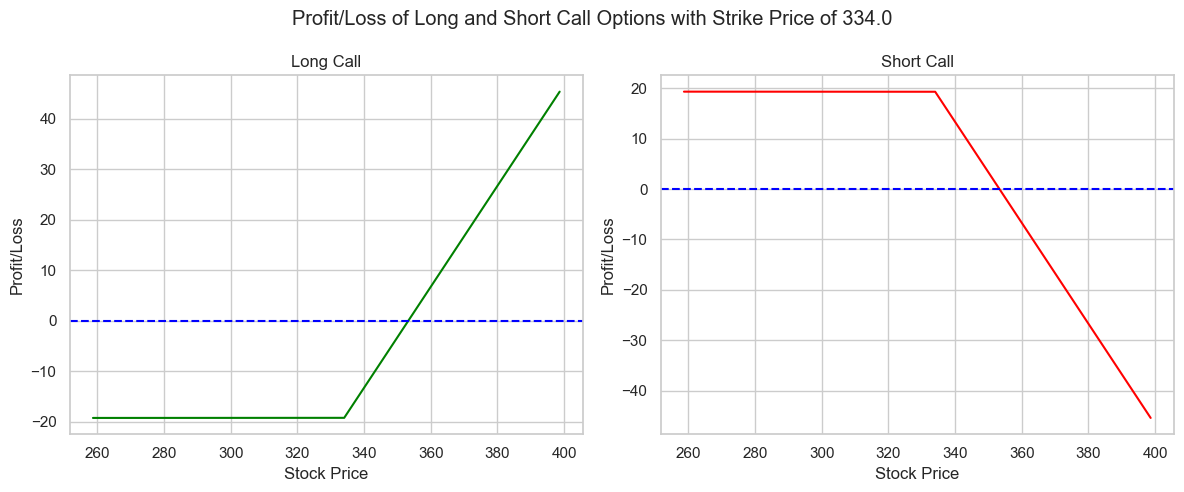

In [37]:
plt.figure(figsize = (12, 5))

# Long Call
plt.subplot(1,2,1)
pnl_call = sns.lineplot(data = call_graph, x = 'stock_price', y = 'pnl_long', color = 'green')
pnl_call.axhline(0, color = 'blue', linestyle = '--')

# Title
plt.title('Long Call')
plt.xlabel('Stock Price')
plt.ylabel('Profit/Loss')

# Short Call
plt.subplot(1,2,2)
pnl_call = sns.lineplot(data = call_graph, x = 'stock_price', y = 'pnl_short', color = 'red')
pnl_call.axhline(0, color = 'blue', linestyle = '--')

# Title
plt.title('Short Call')
plt.xlabel('Stock Price')
plt.ylabel('Profit/Loss')

plt.suptitle(f'Profit/Loss of Long and Short Call Options with Strike Price of {K}')
plt.tight_layout()
plt.show()

In [38]:
c_price

19.2911

- Notably, upon examining the long call option, one can deduce that its maximum potential loss equates to the initial option price, whereas its maximum achievable profit remains unbounded.

- Conversely, the short call option presents an inverse scenario: its maximum potential loss is limitless, whereas its maximum potential profit is constrained to the premium received.

- Furthermore, it's important to note that as the stock price rises, the potential profit achievable from a long call option increases. Conversely, in the context of a short call option, a rising stock price results in amplified potential losses.

### **Put Option**

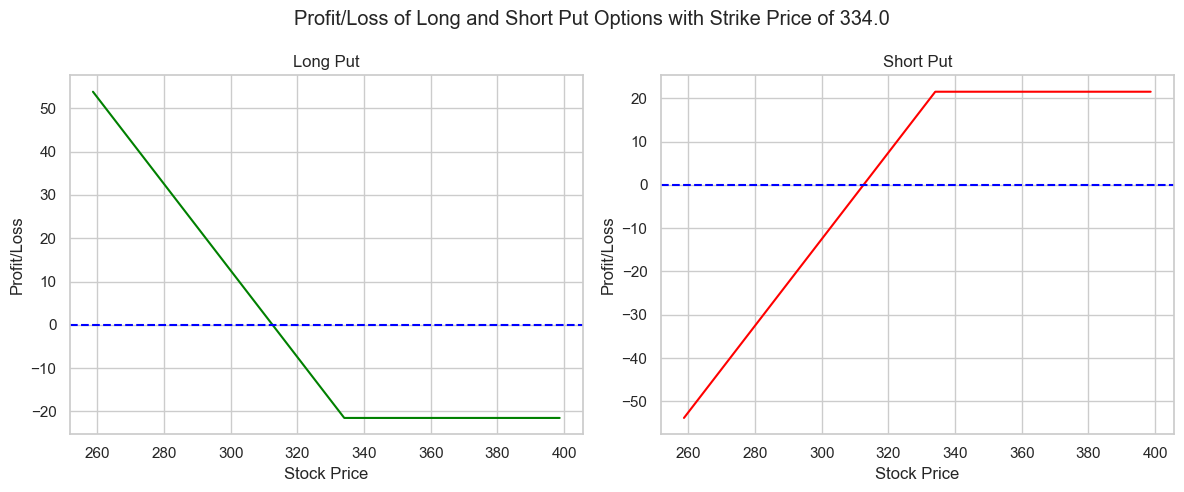

In [39]:
plt.figure(figsize = (12, 5))

# Long Put
plt.subplot(1,2,1)
pnl_put = sns.lineplot(data = put_graph, x = 'stock_price', y = 'pnl_long', color = 'green')
pnl_put.axhline(0, color = 'blue', linestyle = '--')

# Title
plt.title('Long Put')
plt.xlabel('Stock Price')
plt.ylabel('Profit/Loss')

# Short Put
plt.subplot(1,2,2)
pnl_put = sns.lineplot(data = put_graph, x = 'stock_price', y = 'pnl_short', color = 'red')
pnl_put.axhline(0, color = 'blue', linestyle = '--')

# Title
plt.title('Short Put')
plt.xlabel('Stock Price')
plt.ylabel('Profit/Loss')

plt.suptitle(f'Profit/Loss of Long and Short Put Options with Strike Price of {K}')
plt.tight_layout()
plt.show()

In [40]:
p_price

21.5038

- An examination of the long put option reveals that its ultimate potential loss is limited to the initial option price, while its prospective profit remains uncapped.

- In contrast, the short put option showcases an opposing dynamic: its maximum potential loss remains unrestricted, while the highest attainable profit is restricted to the premium received.

- Additionally, it's noteworthy that as the stock price decreases, the potential profit from a long put option increases. Conversely, within the domain of a short put option, a declining stock price leads to escalated potential losses.

---

---

## **Stock Price and Option Price Relationship**

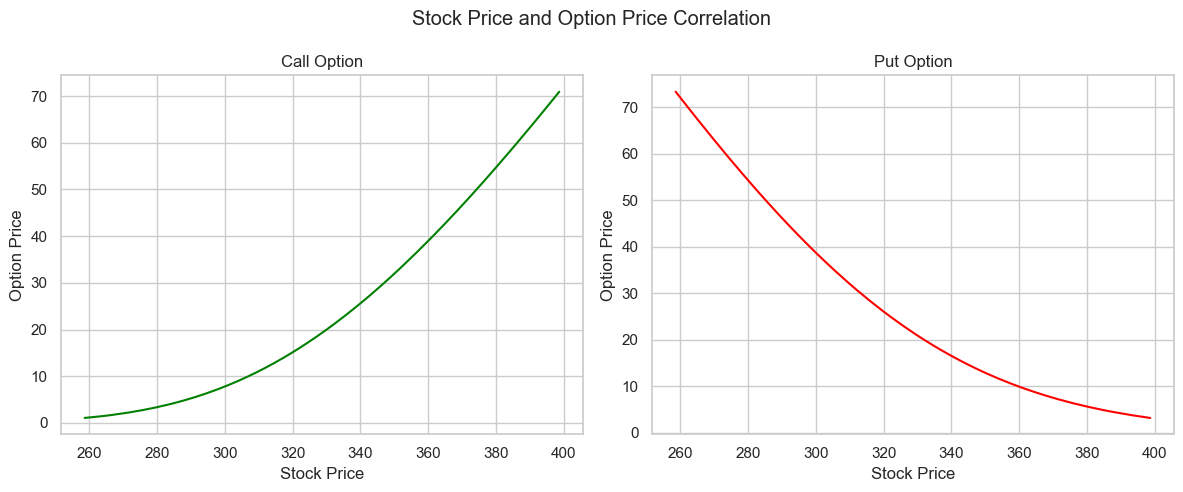

In [41]:
plt.figure(figsize = (12, 5))

# Call Option
plt.subplot(1,2,1)
pnl_call = sns.lineplot(data = call_graph, x = 'stock_price', y = 'call_option_price', color = 'green')

# Title
plt.title('Call Option')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')

# Put Option
plt.subplot(1,2,2)
pnl_call = sns.lineplot(data = put_graph, x = 'stock_price', y = 'put_option_price', color = 'red')

# Title
plt.title('Put Option')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')

plt.suptitle('Stock Price and Option Price Correlation')
plt.tight_layout()
plt.show()

- A clear observation emerges: the price of call options exhibits a positive correlation with the stock price, whereas the price of put options demonstrates an inverse relationship with the stock price. This indicates that as the stock price rises, the call option price tends to increase, while in contrast, as the stock price falls, the put option price tends to rise.

---

---

## **Option Greeks**

Option Greeks are a set of financial metrics that help investors and traders understand the sensitivity of an option's price to various factors. These factors include changes in the underlying asset's price, time until expiration, volatility, interest rates, and more. Option Greeks provide insights into how an option's value might change under different market conditions.

### **Delta**

Delta measures the rate of change in an option's price in relation to a change in the underlying asset's price. It indicates how much the option's value will increase or decrease with a $1 change in the underlying's price. For call options, Delta ranges from 0 to 1, while for put options, it ranges from -1 to 0.

It implies that every $1 increase in the underlying stock price, the value of the option is expected to change by the value of delta. Another implication regarding hedging strategy.

In [42]:
# Call Delta
c_delta

0.5137

In [43]:
# Put Delta
p_delta

-0.5137

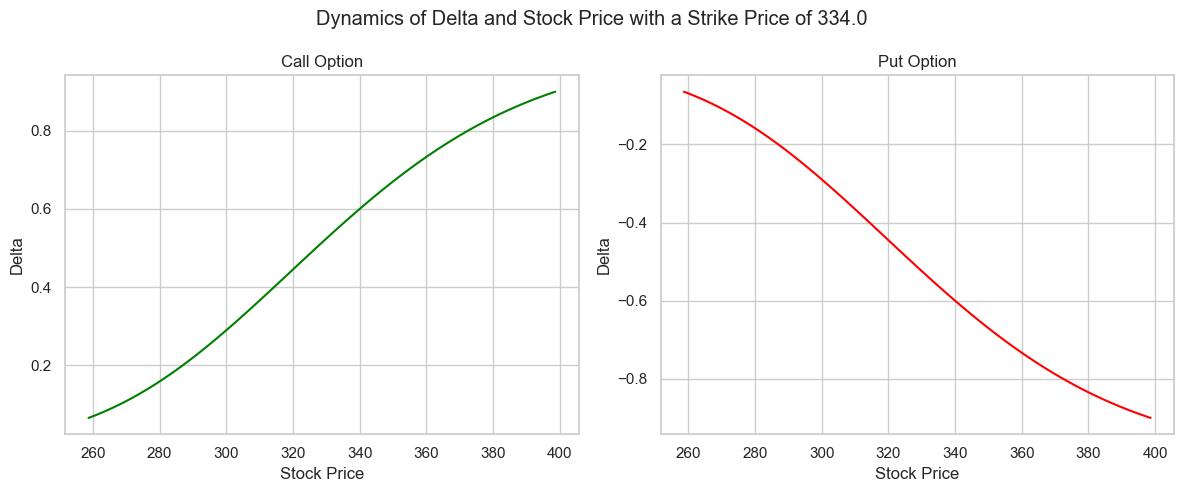

In [44]:
plt.figure(figsize = (12, 5))

# Call Option
plt.subplot(1,2,1)
pnl_call = sns.lineplot(data = call_graph, x = 'stock_price', y = 'call_delta', color = 'green')

# Title
plt.title('Call Option')
plt.xlabel('Stock Price')
plt.ylabel('Delta')

# Put Option
plt.subplot(1,2,2)
pnl_call = sns.lineplot(data = put_graph, x = 'stock_price', y = 'put_delta', color = 'red')

# Title
plt.title('Put Option')
plt.xlabel('Stock Price')
plt.ylabel('Delta')

plt.suptitle(f'Dynamics of Delta and Stock Price with a Strike Price of {K}')
plt.tight_layout()
plt.show()

The term Dynamics of Delta and Stock Price refers to how the delta of options and the stock price interact. This concept is crucial in developing effective hedging strategies.

- Delta and Call Options:
    For call options, as the stock price rises, the delta of the call option typically increases. This means that the call option becomes more sensitive to changes in the stock price. A higher delta indicates that the option's value is more closely aligned with the stock price movement. This behavior is relevant for hedging because if an investor holds a short call option, they might want to buy or hold a certain number of shares of the underlying stock to offset potential losses if the stock price drops.

- Delta and Put Options:
    On the other hand, for put options with a strike price of 322, as the stock price falls, the delta of the put option tends to increase. This implies that the put option becomes more responsive to downward stock price movements. A higher delta indicates a stronger negative correlation between the option's value and the stock price. In terms of hedging, holding a short put option might prompt an investor to short or hold a certain number of shares to mitigate potential losses if the stock price decreases.

In both cases, understanding the dynamics of delta and stock price helps investors devise hedging strategies that aim to offset potential losses from their options positions by taking counteractive positions in the underlying stock. By analyzing how delta changes with stock price movements, investors can fine-tune their hedging approach to align with their risk tolerance and investment goals.

---

### **Theta**

Theta measures the rate of decline in an option's value due to the passage of time. It quantifies how much the option's price will decrease as each day passes, assuming all other factors remain constant. Theta is sometimes referred to as the time decay of the portfolio. It means as the time passes by, the value of option will decrease approximately by the value of theta.

In [45]:
# Call Theta
c_theta

-0.257

In [46]:
# Put Theta
p_theta

-0.1879

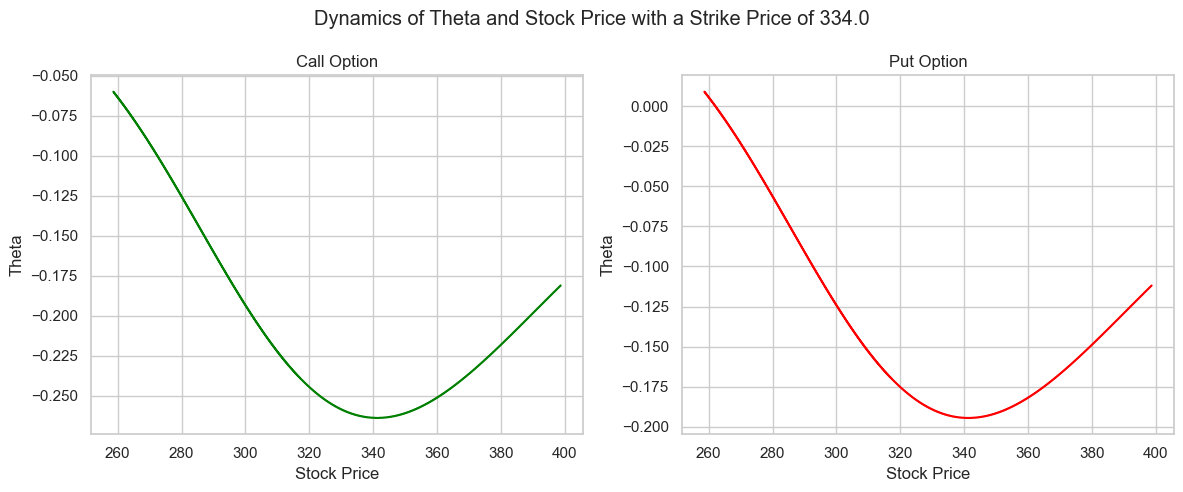

In [47]:
plt.figure(figsize = (12, 5))

# Call Option
plt.subplot(1,2,1)
pnl_call = sns.lineplot(data = call_graph, x = 'stock_price', y = 'call_theta', color = 'green')

# Title
plt.title('Call Option')
plt.xlabel('Stock Price')
plt.ylabel('Theta')

# Put Option
plt.subplot(1,2,2)
pnl_call = sns.lineplot(data = put_graph, x = 'stock_price', y = 'put_theta', color = 'red')

# Title
plt.title('Put Option')
plt.xlabel('Stock Price')
plt.ylabel('Theta')

plt.suptitle(f'Dynamics of Theta and Stock Price with a Strike Price of {K}')
plt.tight_layout()
plt.show()

---

### **Gamma**

Gamma represents the rate of change of an option's Delta in response to a change in the underlying's price. It helps assess the potential change in Delta as the underlying asset's price moves. If gamma is highly negative or highly positive, delta is very sensitive to the price of the underlying asset, respectively.

In [48]:
# Call Gamma
c_gamma

0.0078

In [49]:
# Put Gamma
p_gamma

0.0078

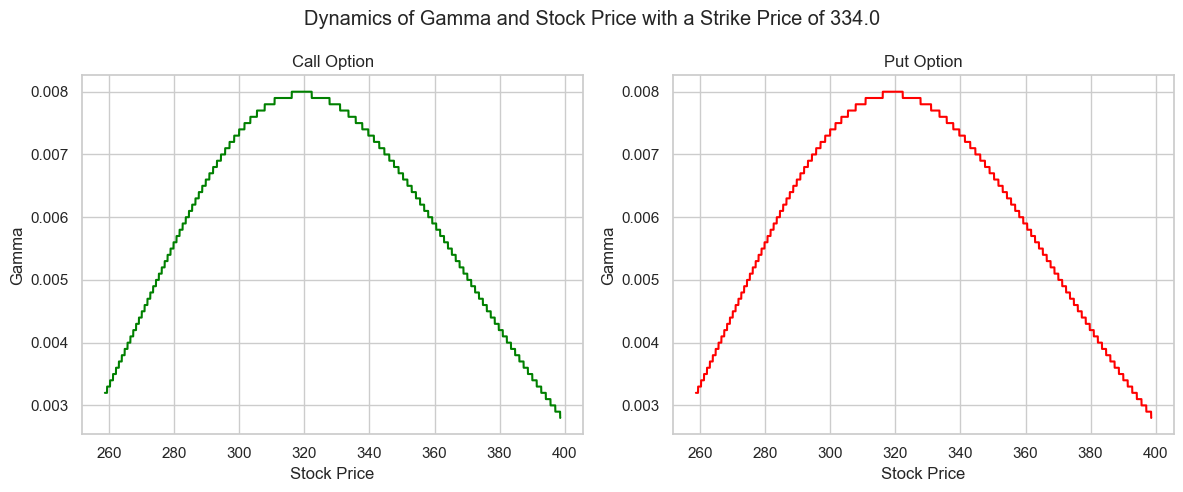

In [50]:
plt.figure(figsize = (12, 5))

# Call Option
plt.subplot(1,2,1)
pnl_call = sns.lineplot(data = call_graph, x = 'stock_price', y = 'call_gamma', color = 'green')

# Title
plt.title('Call Option')
plt.xlabel('Stock Price')
plt.ylabel('Gamma')

# Put Option
plt.subplot(1,2,2)
pnl_call = sns.lineplot(data = put_graph, x = 'stock_price', y = 'put_gamma', color = 'red')

# Title
plt.title('Put Option')
plt.xlabel('Stock Price')
plt.ylabel('Gamma')

plt.suptitle(f'Dynamics of Gamma and Stock Price with a Strike Price of {K}')
plt.tight_layout()
plt.show()

---

### **Vega**

Vega gauges an option's sensitivity to changes in implied volatility. It shows how much the option's price will change for a 1% increase in volatility. Higher Vega values indicate a greater impact of volatility on the option's price.

In [51]:
# Call Vega
c_vega

20.3185

In [52]:
# Put Vega
p_vega

20.3185

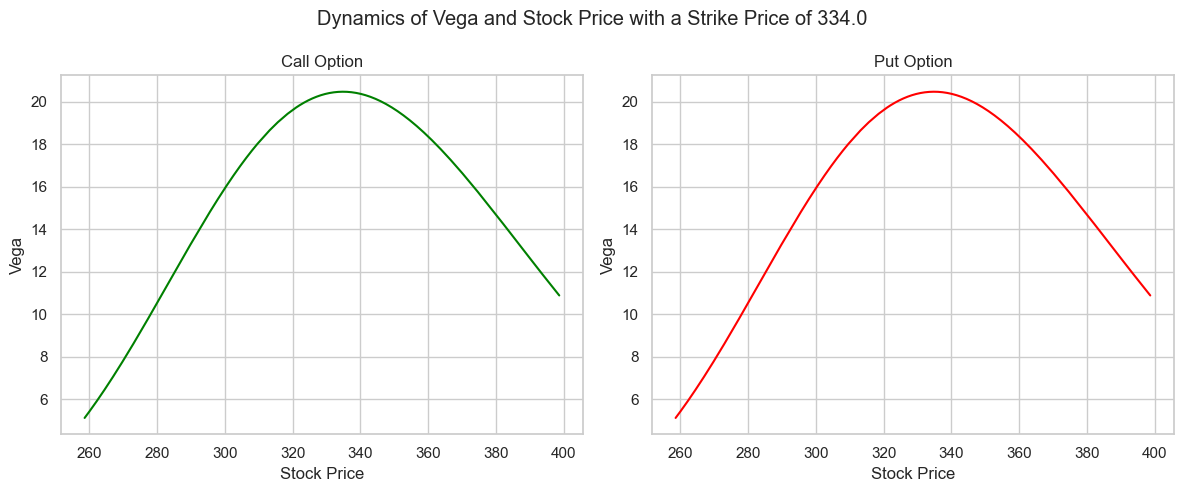

In [53]:
plt.figure(figsize = (12, 5))

# Call Option
plt.subplot(1,2,1)
pnl_call = sns.lineplot(data = call_graph, x = 'stock_price', y = 'call_vega', color = 'green')

# Title
plt.title('Call Option')
plt.xlabel('Stock Price')
plt.ylabel('Vega')

# Put Option
plt.subplot(1,2,2)
pnl_call = sns.lineplot(data = put_graph, x = 'stock_price', y = 'put_vega', color = 'red')

# Title
plt.title('Put Option')
plt.xlabel('Stock Price')
plt.ylabel('Vega')

plt.suptitle(f'Dynamics of Vega and Stock Price with a Strike Price of {K}')
plt.tight_layout()
plt.show()

---

### **Rho**

Rho measures the impact of changes in interest rates on an option's price. It indicates how much an option's value will change for a 1% change in interest rates.

In [54]:
# Call Rho
c_rho

26.7016

In [55]:
# Put Rho
p_rho

-32.3828

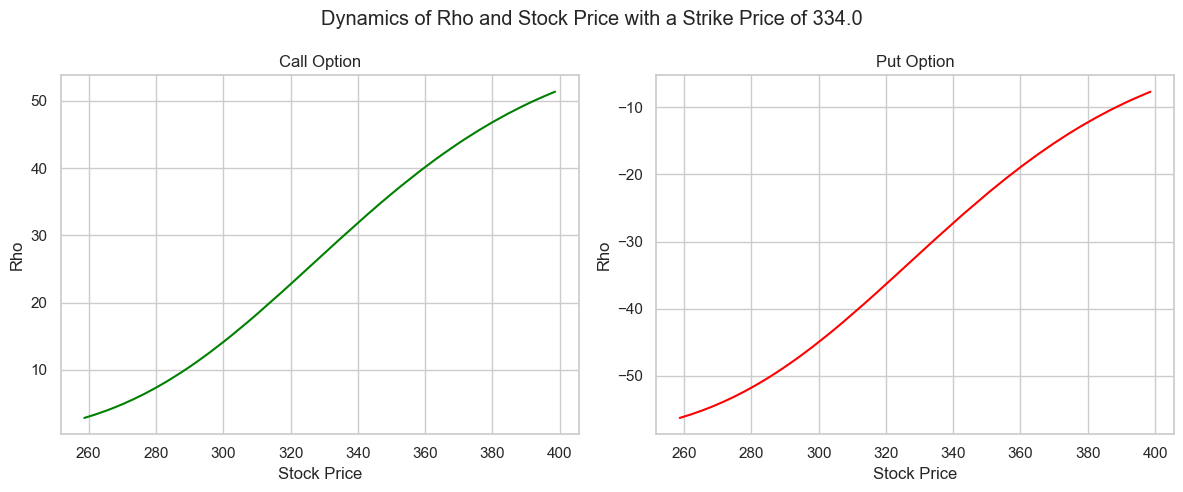

In [56]:
plt.figure(figsize = (12, 5))

# Call Option
plt.subplot(1,2,1)
pnl_call = sns.lineplot(data = call_graph, x = 'stock_price', y = 'call_rho', color = 'green')

# Title
plt.title('Call Option')
plt.xlabel('Stock Price')
plt.ylabel('Rho')

# Put Option
plt.subplot(1,2,2)
pnl_call = sns.lineplot(data = put_graph, x = 'stock_price', y = 'put_rho', color = 'red')

# Title
plt.title('Put Option')
plt.xlabel('Stock Price')
plt.ylabel('Rho')

plt.suptitle(f'Dynamics of Rho and Stock Price with a Strike Price of {K}')
plt.tight_layout()
plt.show()

---

---

## **3D Graphs**

### **Option Greeks as a function of Stock Price and Time to Maturity.**

In [57]:
from itertools import product

stock_price = np.arange(S-100,S+120,0.1)
ttm = np.arange(t,0, -1)

data = list(product(stock_price, ttm))

graph_3d = pd.DataFrame(data, columns=['stock_price', 'ttm'])
graph_3d

,stock_price,ttm
0,228.66,45
1,228.66,44
2,228.66,43
3,228.66,42
4,228.66,41
...,...,...
98995,448.56,5
98996,448.56,4
98997,448.56,3
98998,448.56,2


In [58]:
list_greeks = ['delta', 'theta', 'gamma', 'vega', 'rho']

for index, greek in enumerate(list_greeks):
    graph_3d[f'call_{greek}'] = bs(S = graph_3d.stock_price, K = K, t = graph_3d.ttm, r = r, sigma = sigma, option_type = 'c')[index+1]

In [59]:
graph_3d.head()

,stock_price,ttm,call_delta,call_theta,call_gamma,call_vega,call_rho
0,228.66,45,0.0106,-0.0115,0.0008,0.9918,0.4099
1,228.66,44,0.0098,-0.0109,0.0007,0.9165,0.3712
2,228.66,43,0.0090,-0.0102,0.0007,0.8441,0.3349
3,228.66,42,0.0083,-0.0096,0.0007,0.7746,0.3009
4,228.66,41,0.0076,-0.0090,0.0006,0.7080,0.2691


---